# ECG Classification

### *Based on [ECG Heartbeat Classification: A Deep Transferable Representation](https://arxiv.org/pdf/1805.00794.pdf) *

In [1]:
import os
print(os.listdir("data/heartbeat/"))

['ptbdb_abnormal.csv', 'ptbdb_normal.csv', 'mitbih_train.csv', 'mitbih_test.csv']


In [2]:
# import libraries
import math
import random
import pickle
import itertools
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
np.random.seed(42)

In [3]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, label_ranking_average_precision_score, label_ranking_loss, coverage_error 
from sklearn.utils import shuffle
from scipy.signal import resample
from sklearn.preprocessing import OneHotEncoder

In [4]:
import tensorflow.keras as keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv1D, MaxPooling1D, Softmax, Add, Flatten, Activation, Dropout
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

## Read Dataset

In [5]:
# catenate df and df2 together
df = pd.read_csv("data/heartbeat/mitbih_train.csv", header=None)
df2 = pd.read_csv("data/heartbeat/mitbih_test.csv", header=None)
df = pd.concat([df, df2], axis=0)

In [6]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,0.044118,0.061275,0.066176,0.061275,0.049020,0.073529,0.061275,0.061275,0.066176,0.068627,0.095588,0.075980,0.093137,0.105392,0.115196,0.102941,0.117647,0.125000,0.142157,0.127451,0.151961,0.144608,0.164216,0.144608,0.159314,0.151961,0.154412,0.142157,0.151961,0.151961,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,0.074074,0.062678,0.065527,0.065527,0.062678,0.076923,0.071225,0.082621,0.091168,0.096866,0.082621,0.082621,0.091168,0.105413,0.122507,0.148148,0.182336,0.193732,0.213675,0.207977,0.222222,0.253561,0.270655,0.287749,0.284900,0.293447,0.256410,0.247863,0.188034,0.145299,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,0.056757,0.043243,0.067568,0.062162,0.078378,0.072973,0.086486,0.081081,0.108108,0.110811,0.135135,0.135135,0.170270,0.183784,0.216216,0.237838,0.270270,0.286486,0.316216,0.318919,0.332432,0.297297,0.267568,0.216216,0.189189,0.132432,0.118919,0.064865,0.064865,0.043243,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,0.063536,0.082873,0.085635,0.093923,0.113260,0.124309,0.140884,0.132597,0.140884,0.091160,0.085635,0.074586,0.071823,0.080110,0.096685,0.118785,0.138122,0.140884,0.138122,0.146409,0.110497,0.102210,0.060773,0.027624,0.038674,0.013812,0.011050,0.013812,0.033149,0.005525,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,0.131455,0.122066,0.140845,0.159624,0.150235,0.145540,0.136150,0.169014,0.178404,0.173709,0.183099,0.201878,0.187793,0.164319,0.187793,0.215962,0.215962,0.201878,0.211268,0.230047,0.215962,0.230047,0.239437,0.267606,0.253521,0.230047,0.220657,0.225352,0.211268,0.173709,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 109446 entries, 0 to 21891
Columns: 188 entries, 0 to 187
dtypes: float64(188)
memory usage: 157.8 MB


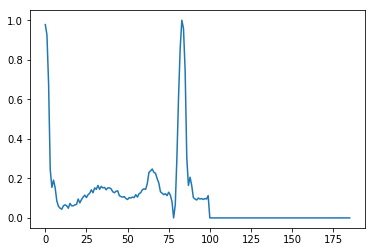

In [8]:
# show one data
plt.plot(df.iloc[0,:186])

## Dataset Balance

In [9]:
equilibre=df[187].value_counts()
print(equilibre)

0.0    90589
4.0     8039
2.0     7236
1.0     2779
3.0      803
Name: 187, dtype: int64


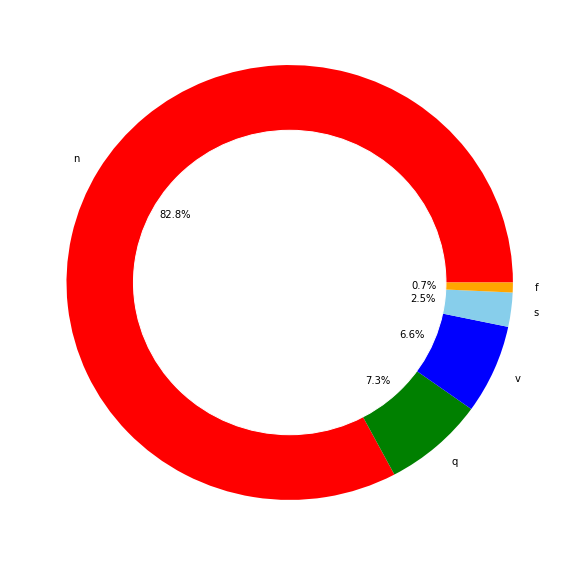

In [10]:
# plot the circle of value counts in dataset
plt.figure(figsize=(10,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(equilibre, labels=['n','q','v','s','f'], colors=['red','green','blue','skyblue','orange'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

In [11]:
M = df.values
X = M[:, :-1]
y = M[:, -1].astype(int)

In [12]:
del df
del df2
del M

## Visual Input

In [13]:
C0 = np.argwhere(y == 0).flatten()
C1 = np.argwhere(y == 1).flatten()
C2 = np.argwhere(y == 2).flatten()
C3 = np.argwhere(y == 3).flatten()
C4 = np.argwhere(y == 4).flatten()

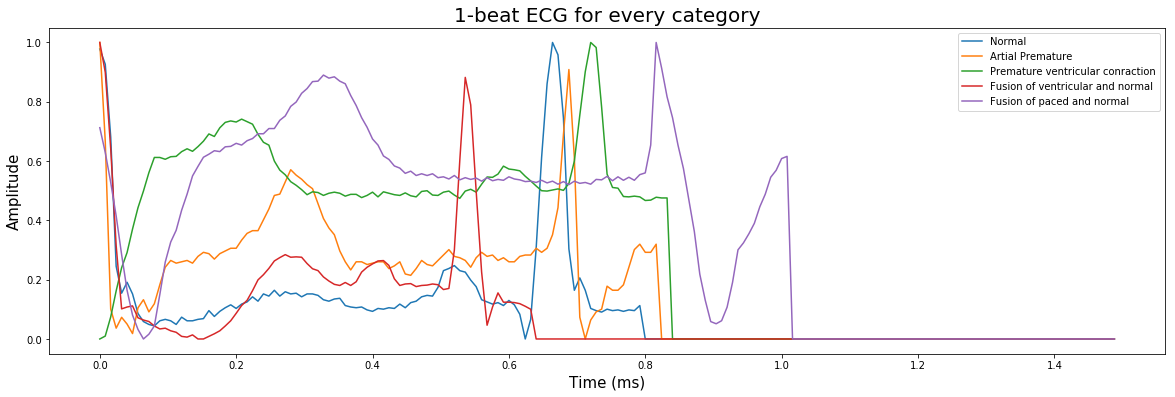

In [14]:
x = np.arange(0, 187)*8/1000

plt.figure(figsize=(20,6))
plt.plot(x, X[C0, :][0], label="Normal")
plt.plot(x, X[C1, :][0], label="Artial Premature")
plt.plot(x, X[C2, :][0], label="Premature ventricular conraction")
plt.plot(x, X[C3, :][0], label="Fusion of ventricular and normal")
plt.plot(x, X[C4, :][0], label="Fusion of paced and normal")
plt.legend()
plt.title("1-beat ECG for every category", fontsize=20)
plt.ylabel("Amplitude", fontsize=15)
plt.xlabel("Time (ms)", fontsize=15)
plt.show()

## Data augmentation

To train properly the model, we sould have to augment all data to the same level. Nevertheless, for a first try, we will just augment the smallest class to the same level as class 1. With that we will be able to have a test set of around 5x800 observations.

In [15]:
def stretch(x):
    l = int(187 * (1 + (random.random()-0.5)/3))
    y = resample(x, l)
    if l < 187:
        y_ = np.zeros(shape=(187, ))
        y_[:l] = y
    else:
        y_ = y[:187]
    return y_

def amplify(x):
    alpha = (random.random()-0.5)
    factor = -alpha*x + (1+alpha)
    return x*factor

def augment(x):
    result = np.zeros(shape= (4, 187))
    for i in range(3):
        if random.random() < 0.33:
            new_y = stretch(x)
        elif random.random() < 0.66:
            new_y = amplify(x)
        else:
            new_y = stretch(x)
            new_y = amplify(new_y)
        result[i, :] = new_y
    return result

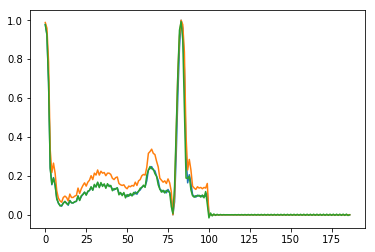

In [16]:
plt.plot(X[0, :])
plt.plot(amplify(X[0, :]))
plt.plot(stretch(X[0, :]))
plt.show()

In [17]:
result = np.apply_along_axis(augment, axis=1, arr=X[C3]).reshape(-1, 187)
classe = np.ones(shape=(result.shape[0],), dtype=int)*3
X = np.vstack([X, result])
y = np.hstack([y, classe])

## Split Dataset

In [18]:
# randomly choose 800 data as Testset
subC0 = np.random.choice(C0, 800)
subC1 = np.random.choice(C1, 800)
subC2 = np.random.choice(C2, 800)
subC3 = np.random.choice(C3, 800)
subC4 = np.random.choice(C4, 800)

In [19]:
# Testset = 800x5 = 4000
X_test = np.vstack([X[subC0], X[subC1], X[subC2], X[subC3], X[subC4]])
y_test = np.hstack([y[subC0], y[subC1], y[subC2], y[subC3], y[subC4]])
# Trainset = remove testset from dataset
X_train = np.delete(X, [subC0, subC1, subC2, subC3, subC4], axis=0)
y_train = np.delete(y, [subC0, subC1, subC2, subC3, subC4], axis=0)

X_train, y_train = shuffle(X_train, y_train, random_state=0)
X_test, y_test = shuffle(X_test, y_test, random_state=0)

del X
del y

In [20]:
X_train = np.expand_dims(X_train, 2)
X_test = np.expand_dims(X_test, 2)

In [21]:
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train (109150, 187, 1)
y_train (109150,)
X_test (4000, 187, 1)
y_test (4000,)


In [22]:
ohe = OneHotEncoder()
y_train = ohe.fit_transform(y_train.reshape(-1,1))
y_test = ohe.transform(y_test.reshape(-1,1))

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:405: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [23]:
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train (109150, 187, 1)
y_train (109150, 5)
X_test (4000, 187, 1)
y_test (4000, 5)


## Build Model

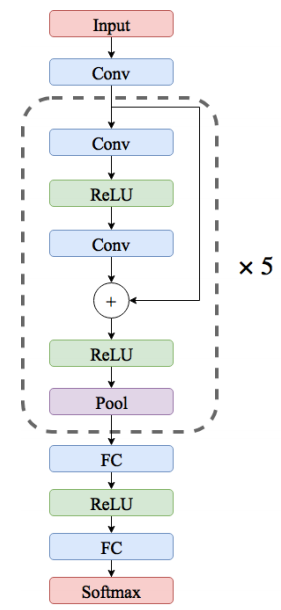

In [24]:
n_obs, feature, depth = X_train.shape
batch_size = 100

In [25]:
# Build Model
inp = Input(shape=(feature, depth))
C = Conv1D(filters=32, kernel_size=5, strides=1)(inp)

C11 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(C)
A11 = Activation("relu")(C11)
C12 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A11)
S11 = Add()([C12, C])
A12 = Activation("relu")(S11)
M11 = MaxPooling1D(pool_size=5, strides=2)(A12)


C21 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(M11)
A21 = Activation("relu")(C21)
C22 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A21)
S21 = Add()([C22, M11])
A22 = Activation("relu")(S11)
M21 = MaxPooling1D(pool_size=5, strides=2)(A22)


C31 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(M21)
A31 = Activation("relu")(C31)
C32 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A31)
S31 = Add()([C32, M21])
A32 = Activation("relu")(S31)
M31 = MaxPooling1D(pool_size=5, strides=2)(A32)


C41 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(M31)
A41 = Activation("relu")(C41)
C42 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A41)
S41 = Add()([C42, M31])
A42 = Activation("relu")(S41)
M41 = MaxPooling1D(pool_size=5, strides=2)(A42)


C51 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(M41)
A51 = Activation("relu")(C51)
C52 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A51)
S51 = Add()([C52, M41])
A52 = Activation("relu")(S51)
M51 = MaxPooling1D(pool_size=5, strides=2)(A52)

F1 = Flatten()(M51)

D1 = Dense(32)(F1)
A6 = Activation("relu")(D1)
D2 = Dense(32)(A6)
D3 = Dense(5)(D2)
A7 = Softmax()(D3)

model = Model(inputs=inp, outputs=A7)

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 187, 1)       0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 183, 32)      192         input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 183, 32)      5152        conv1d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 183, 32)      0           conv1d_1[0][0]                   
__________________________________________________________________________________________________
conv1d_2 (

In [26]:
# Compile Model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

## Train Model

In [27]:
# train more epochs to increase accuracy 
num_epochs = 10 # 75

In [28]:
# Train Model
history = model.fit(X_train, y_train, epochs=num_epochs, batch_size=batch_size, validation_data=(X_test, y_test))

Train on 109150 samples, validate on 4000 samples
Epoch 1/10
109150/109150 [==============================] - 129s 1ms/step - loss: 0.1935 - acc: 0.9449 - val_loss: 0.6478 - val_acc: 0.8297
Epoch 2/10
109150/109150 [==============================] - 127s 1ms/step - loss: 0.0911 - acc: 0.9741 - val_loss: 0.4091 - val_acc: 0.8810
Epoch 3/10
109150/109150 [==============================] - 128s 1ms/step - loss: 0.0714 - acc: 0.9796 - val_loss: 0.3671 - val_acc: 0.8808
Epoch 4/10
109150/109150 [==============================] - 127s 1ms/step - loss: 0.0606 - acc: 0.9817 - val_loss: 0.3593 - val_acc: 0.8958
Epoch 5/10
109150/109150 [==============================] - 129s 1ms/step - loss: 0.0545 - acc: 0.9832 - val_loss: 0.3381 - val_acc: 0.9075
Epoch 6/10
109150/109150 [==============================] - 128s 1ms/step - loss: 0.0494 - acc: 0.9850 - val_loss: 0.2385 - val_acc: 0.9213
Epoch 7/10
109150/109150 [==============================] - 131s 1ms/step - loss: 0.0452 - acc: 0.9860 - val_l

## Save Model

In [29]:
# Save Model
model.save("ecg_arrhythmia.h5")

## Test Model

In [30]:
# Test Model
y_pred = model.predict(X_test, batch_size=1000)

In [31]:
print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))

             precision    recall  f1-score   support

          0       0.79      0.99      0.88       800
          1       1.00      0.78      0.88       800
          2       0.94      0.95      0.95       800
          3       0.99      0.93      0.96       800
          4       0.99      0.99      0.99       800

avg / total       0.94      0.93      0.93      4000



In [32]:
print("ranking-based average precision : {:.3f}".format(label_ranking_average_precision_score(y_test.todense(), y_pred)))
print("Ranking loss : {:.3f}".format(label_ranking_loss(y_test.todense(), y_pred)))
print("Coverage_error : {:.3f}".format(coverage_error(y_test.todense(), y_pred)))

ranking-based average precision : 0.963
Ranking loss : 0.021
Coverage_error : 1.084
